# Graph testing
This is a notebook that can be used to play around with graphs and get instant feedback (instead of passing it to html and running the server.)

It was tricky to get Jupyter to run Django, and I hope it is reproducible.  To run this, Jupyter must be launched from within pipenv.  And while there might be a way to run a notebook in a subdirectory, I could only get it to work when the notebook is in the root folder.

## Setup code

In [1]:
import os, sys
configuration = os.getenv('ENVIRONMENT', 'development').title()
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'planningportal.settings')
os.environ.setdefault('DJANGO_CONFIGURATION', configuration)
from configurations.management import execute_from_command_line
import django
django.setup()

In [5]:
from ppts.views import *

%matplotlib inline

## Graph workspace

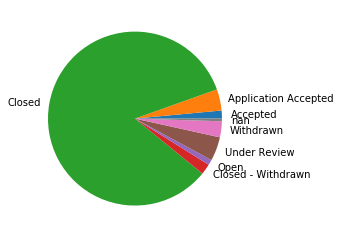

In [16]:
#sample graph
fig,ax = plt.subplots()
    
projects = Record.objects.filter(record_type__pk = 'PRJ').values('status').annotate(status_counts = Count('pk'))
status_counts = []
status = []
for item in projects:
    status.append(item['status'])
    status_counts.append(item['status_counts'])

plt.show(ax.pie(status_counts, labels=status))